In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from polars_bloomberg import BQuery


## Nasdaq-RTY Spread Mean Reversion

This notebook analyzes a mean reversion trading strategy on the NDX (Nasdaq 100) vs RTY (Russell 2000) spread.

### Strategy Overview
- **Signal**: When the 2-day spread z-score drops below -1 (RTY outperforms), go LONG the spread (Long NDX, Short RTY)
- **Hypothesis**: Tech mega-caps (NDX) have structural outperformance vs small caps (RTY), creating asymmetric mean reversion
- **Key Finding**: Only the long spread side (z < -1) shows profitable mean reversion with 58% hit ratio

In [2]:
NDX = "NQ1 Index"
RTY = "RTY1 Index"
tickers = [NDX, RTY]
fields = ["CHG_PCT_1D"]

with BQuery() as bq:
    df = bq.bdh(tickers, fields, pd.Timestamp("2010-01-01"), pd.Timestamp.today())
df = (
    df.pivot(index="date", on="security", values="CHG_PCT_1D")
    .to_pandas()
    .set_index("date")
    .dropna()
    / 100
)
logret = df.apply(np.log1p)
logret["long_ndx_short_rty"] = logret[NDX] - logret[RTY]
logret["long_ndx_short_rty_2d"] = logret["long_ndx_short_rty"].rolling(window=2).sum()
logret["std"] = (
    logret["long_ndx_short_rty_2d"]
    .pow(2)
    .rolling(window=252, min_periods=252)
    .mean()
    .pow(0.5)
)
logret["z"] = logret["long_ndx_short_rty_2d"] / logret["std"]
logret["long_ndx_short_rty_2d_fwd"] = logret["long_ndx_short_rty_2d"].shift(-2)

# OPTIMIZED STRATEGY: Only trade long spread when z < -1
# Analysis showed short spread (z > 1) has negative expected value
logret["signal"] = 0
logret.loc[
    logret["z"] < -1, "signal"
] = -1  # Long the spread when z < -1 (RTY outperforms)

In [3]:
# ============================================================================
# CURRENT SIGNAL - WHAT TO DO TODAY
# ============================================================================

current_z = logret["z"].iloc[-1]
current_signal = logret["signal"].iloc[-1]
current_date = logret.index[-1]

print("=" * 80)
print("CURRENT SIGNAL - LIVE TRADING RECOMMENDATION")
print("=" * 80)
print(f"\nAs of: {current_date.strftime('%Y-%m-%d')}")
print(f"Current Z-Score: {current_z:.4f}")
print(f"Signal Threshold: -1.0000")
print("")

if current_signal == -1:
    print("🟢 SIGNAL: LONG THE SPREAD")
    print("   Position: LONG NDX (Nasdaq 100) / SHORT RTY (Russell 2000)")
    print(
        "   Rationale: RTY has outperformed (z < -1), expecting NDX to reclaim leadership"
    )
    print("")
    print("   Implementation:")
    print("   - Buy NQ1 Index futures (or QQQ ETF)")
    print("   - Short RTY1 Index futures (or IWM ETF)")
    print("   - Equal dollar amounts on each side")
elif current_signal == 0:
    print("⚪ SIGNAL: NO POSITION")
    print("   Action: Stay flat / Exit existing positions")
    print("   Rationale: Z-score not extreme enough (must be < -1 for entry)")
    print("")
    if current_z > -1 and current_z < 0:
        print(
            f"   Note: Z-score at {current_z:.2f} - Getting closer to signal threshold"
        )
    elif current_z >= 0:
        print(f"   Note: Z-score at {current_z:.2f} - NDX is outperforming (positive)")
else:
    print("⚠️  UNEXPECTED SIGNAL VALUE")

print("=" * 80)

CURRENT SIGNAL - LIVE TRADING RECOMMENDATION

As of: 2025-11-12
Current Z-Score: -0.1502
Signal Threshold: -1.0000

⚪ SIGNAL: NO POSITION
   Action: Stay flat / Exit existing positions
   Rationale: Z-score not extreme enough (must be < -1 for entry)

   Note: Z-score at -0.15 - Getting closer to signal threshold


In [4]:
# Calculate 1d forward spread return as well
logret["long_ndx_short_rty_1d_fwd"] = logret["long_ndx_short_rty"].shift(-1)

# Create analysis dataframe
analysis_df = logret[
    ["z", "signal", "long_ndx_short_rty_2d_fwd", "long_ndx_short_rty_1d_fwd"]
].dropna()

print("=" * 80)
print("Z-SCORE SIGNAL ANALYSIS")
print("=" * 80)
print(f"\nTotal observations: {len(analysis_df)}")
print(f"Signal = -1 (z < -1, long spread): {(analysis_df['signal'] == -1).sum()}")
print(f"Signal = 0 (no signal): {(analysis_df['signal'] == 0).sum()}")
print(
    f"\nStrategy trades only when RTY outperforms (z < -1), betting on NDX to reclaim leadership"
)

Z-SCORE SIGNAL ANALYSIS

Total observations: 1848
Signal = -1 (z < -1, long spread): 211
Signal = 0 (no signal): 1637

Strategy trades only when RTY outperforms (z < -1), betting on NDX to reclaim leadership


In [5]:
# HIT RATIO ANALYSIS
print("\n" + "=" * 80)
print("HIT RATIO ANALYSIS (2D Forward Returns)")
print("=" * 80)

# For z < -1 signals (LONG spread): we expect positive forward spread returns
long_signals = analysis_df[analysis_df["signal"] == -1]
if len(long_signals) > 0:
    long_hits = (long_signals["long_ndx_short_rty_2d_fwd"] > 0).sum()
    long_hit_ratio = long_hits / len(long_signals) * 100
    long_avg_return = long_signals["long_ndx_short_rty_2d_fwd"].mean()
    long_median_return = long_signals["long_ndx_short_rty_2d_fwd"].median()
    print(f"\nWhen z < -1 (LONG spread - Long NDX, Short RTY):")
    print(f"  Observations: {len(long_signals)}")
    print(f"  Hit Ratio: {long_hit_ratio:.2f}% (forward spread > 0)")
    print(f"  Avg 2d fwd spread return: {long_avg_return:.4%}")
    print(f"  Median 2d fwd spread return: {long_median_return:.4%}")
    print(f"  Expected P&L per trade: {long_avg_return:.4%}")

    # Statistical significance
    from scipy import stats

    t_stat, p_value = stats.ttest_1samp(long_signals["long_ndx_short_rty_2d_fwd"], 0)
    print(f"\n  Statistical Test (H0: mean = 0):")
    print(f"    t-statistic: {t_stat:.4f}")
    print(f"    p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"    Result: Statistically significant at 5% level ✓")
    else:
        print(f"    Result: Not statistically significant at 5% level")


HIT RATIO ANALYSIS (2D Forward Returns)

When z < -1 (LONG spread - Long NDX, Short RTY):
  Observations: 211
  Hit Ratio: 58.29% (forward spread > 0)
  Avg 2d fwd spread return: 0.3704%
  Median 2d fwd spread return: 0.3524%
  Expected P&L per trade: 0.3704%



  Statistical Test (H0: mean = 0):
    t-statistic: 3.0168
    p-value: 0.0029
    Result: Statistically significant at 5% level ✓


In [6]:
# CORRELATION ANALYSIS
print("\n" + "=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Overall correlation
corr_2d = analysis_df["z"].corr(analysis_df["long_ndx_short_rty_2d_fwd"])
corr_1d = analysis_df["z"].corr(analysis_df["long_ndx_short_rty_1d_fwd"])

print(f"\nCorrelation between z-score and 2d forward spread return: {corr_2d:.4f}")
print(f"Correlation between z-score and 1d forward spread return: {corr_1d:.4f}")

# The correlation should be NEGATIVE if mean reversion works:
# High z-score -> spread should go down
# Low z-score -> spread should go up
print(f"\nInterpretation:")
if corr_2d < 0:
    print(f"  ✓ Negative correlation suggests mean reversion is working")
    print(
        f"    (High z-scores followed by spread declines, low z-scores by spread increases)"
    )
else:
    print(f"  ✗ Positive correlation suggests momentum/trending behavior")
    print(f"    (High z-scores followed by further spread increases)")

# Correlation for our trading signal
print("\n" + "-" * 80)
print("Correlation for LONG Spread Signals (z < -1):")
print("-" * 80)

if len(long_signals) > 0:
    corr_long = long_signals["z"].corr(long_signals["long_ndx_short_rty_2d_fwd"])
    print(f"\nWhen z < -1 (LONG signals):")
    print(f"  Correlation(z, 2d fwd return): {corr_long:.4f}")
    if corr_long < 0:
        print(f"  ✓ Negative correlation confirms mean reversion in this regime")

# Spearman rank correlation (non-parametric)
from scipy.stats import spearmanr

spearman_corr_2d, spearman_pval_2d = spearmanr(
    analysis_df["z"], analysis_df["long_ndx_short_rty_2d_fwd"]
)
spearman_corr_1d, spearman_pval_1d = spearmanr(
    analysis_df["z"], analysis_df["long_ndx_short_rty_1d_fwd"]
)

print("\n" + "-" * 80)
print("Spearman Rank Correlation (non-parametric):")
print("-" * 80)
print(f"\nz vs 2d fwd return: {spearman_corr_2d:.4f} (p-value: {spearman_pval_2d:.4e})")
print(f"z vs 1d fwd return: {spearman_corr_1d:.4f} (p-value: {spearman_pval_1d:.4e})")


CORRELATION ANALYSIS

Correlation between z-score and 2d forward spread return: -0.0122
Correlation between z-score and 1d forward spread return: 0.0081

Interpretation:
  ✓ Negative correlation suggests mean reversion is working
    (High z-scores followed by spread declines, low z-scores by spread increases)

--------------------------------------------------------------------------------
Correlation for LONG Spread Signals (z < -1):
--------------------------------------------------------------------------------

When z < -1 (LONG signals):
  Correlation(z, 2d fwd return): -0.1784
  ✓ Negative correlation confirms mean reversion in this regime

--------------------------------------------------------------------------------
Spearman Rank Correlation (non-parametric):
--------------------------------------------------------------------------------

z vs 2d fwd return: -0.0170 (p-value: 4.6511e-01)
z vs 1d fwd return: -0.0076 (p-value: 7.4278e-01)


C:\Users\IgnaciodeRamónJacob-\AppData\Local\Temp\ipykernel_52992\1795395426.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_bucket = analysis_df.groupby("z_bucket")["long_ndx_short_rty_2d_fwd"].agg(


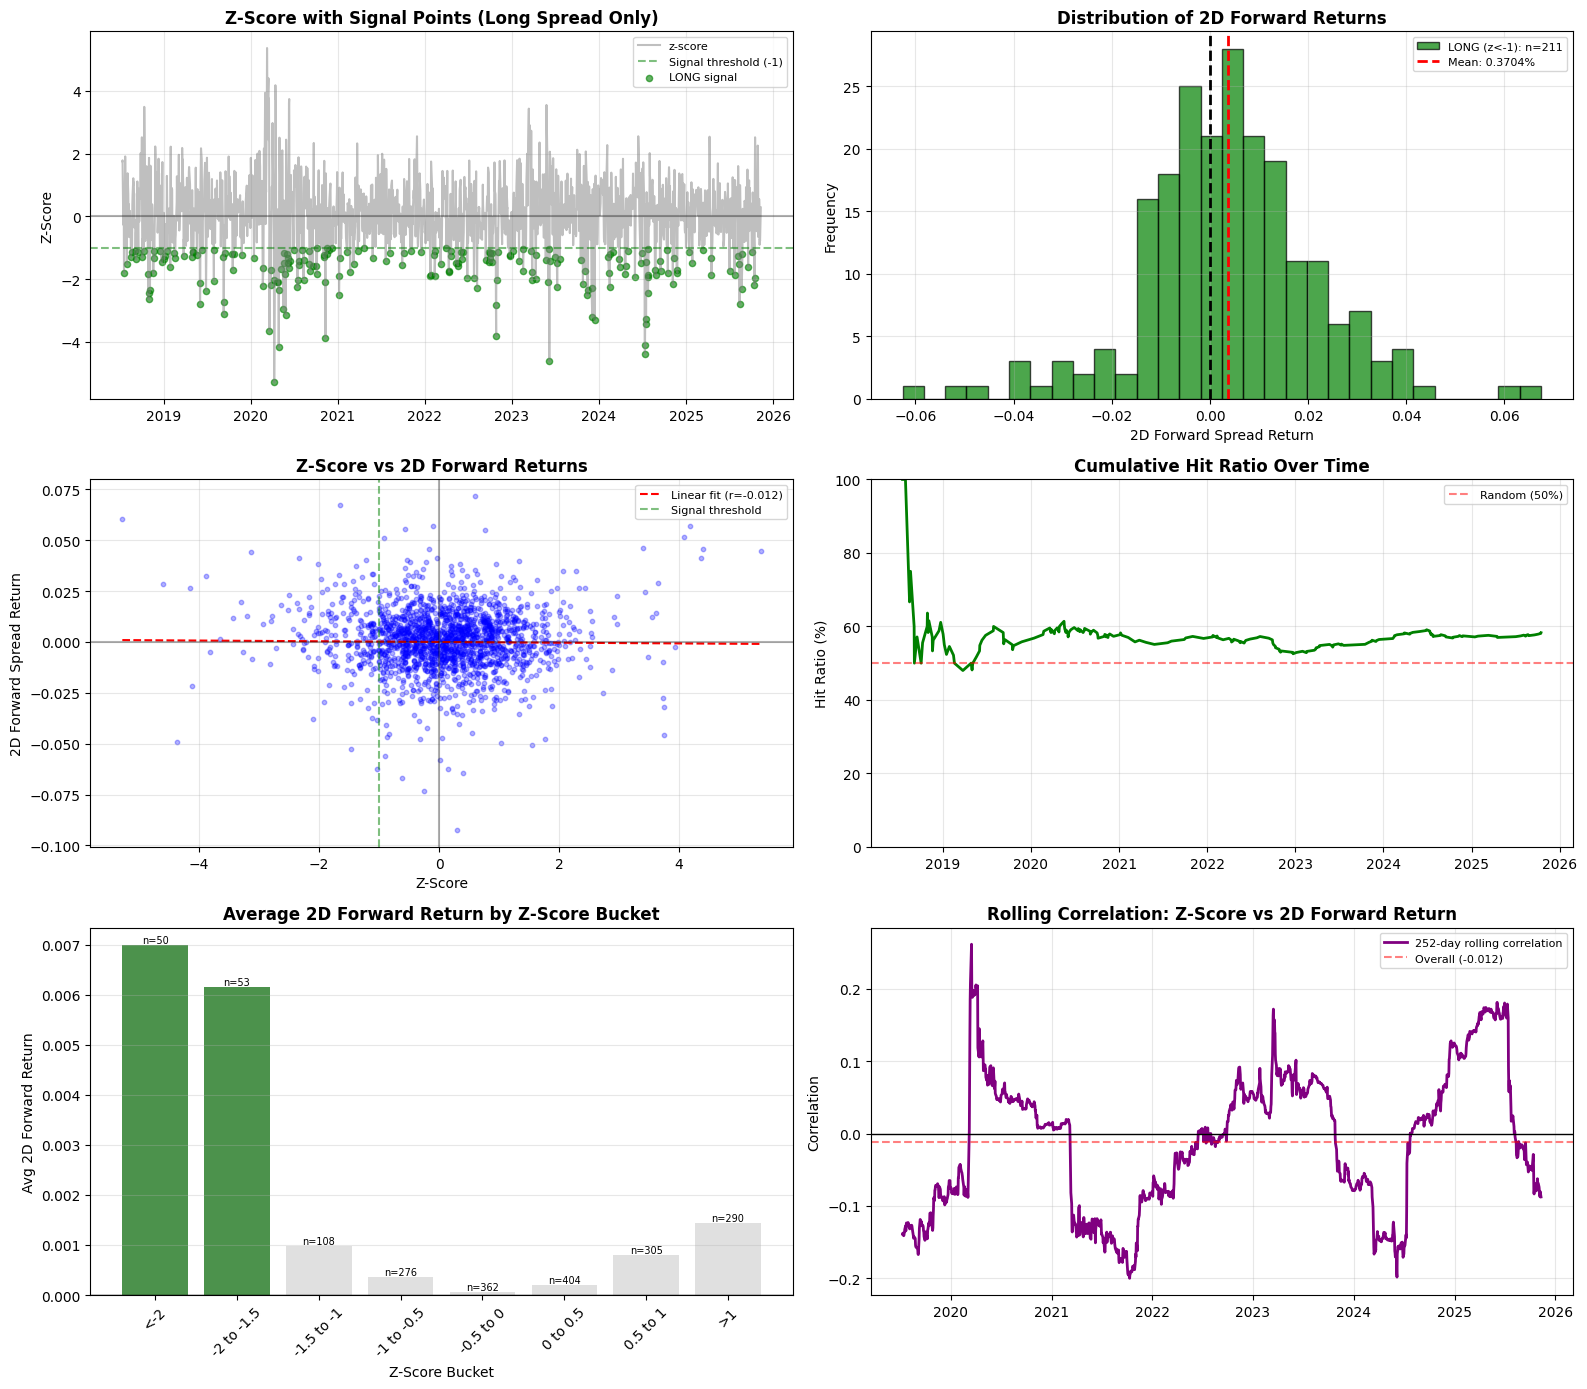

In [7]:
# VISUALIZATIONS
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# 1. Z-score time series with signals
ax1 = axes[0, 0]
ax1.plot(analysis_df.index, analysis_df["z"], color="gray", alpha=0.5, label="z-score")
ax1.axhline(
    y=-1, color="green", linestyle="--", alpha=0.5, label="Signal threshold (-1)"
)
ax1.axhline(y=0, color="black", linestyle="-", alpha=0.3)
ax1.scatter(
    long_signals.index,
    long_signals["z"],
    color="green",
    s=20,
    alpha=0.6,
    label="LONG signal",
)
ax1.set_title(
    "Z-Score with Signal Points (Long Spread Only)", fontsize=12, fontweight="bold"
)
ax1.set_ylabel("Z-Score")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Forward returns distribution for long signals
ax2 = axes[0, 1]
if len(long_signals) > 0:
    ax2.hist(
        long_signals["long_ndx_short_rty_2d_fwd"],
        bins=30,
        alpha=0.7,
        color="green",
        label=f"LONG (z<-1): n={len(long_signals)}",
        edgecolor="black",
    )
ax2.axvline(x=0, color="black", linestyle="--", linewidth=2)
ax2.axvline(
    x=long_signals["long_ndx_short_rty_2d_fwd"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {long_signals['long_ndx_short_rty_2d_fwd'].mean():.4%}",
)
ax2.set_title("Distribution of 2D Forward Returns", fontsize=12, fontweight="bold")
ax2.set_xlabel("2D Forward Spread Return")
ax2.set_ylabel("Frequency")
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Scatter: z-score vs forward returns
ax3 = axes[1, 0]
ax3.scatter(
    analysis_df["z"],
    analysis_df["long_ndx_short_rty_2d_fwd"],
    alpha=0.3,
    s=10,
    color="blue",
)
z_range = np.linspace(analysis_df["z"].min(), analysis_df["z"].max(), 100)
ax3.plot(
    z_range,
    corr_2d
    * z_range
    * analysis_df["long_ndx_short_rty_2d_fwd"].std()
    / analysis_df["z"].std(),
    color="red",
    linestyle="--",
    label=f"Linear fit (r={corr_2d:.3f})",
)
ax3.axhline(y=0, color="black", linestyle="-", alpha=0.3)
ax3.axvline(x=0, color="black", linestyle="-", alpha=0.3)
ax3.axvline(x=-1, color="green", linestyle="--", alpha=0.5, label="Signal threshold")
ax3.set_title("Z-Score vs 2D Forward Returns", fontsize=12, fontweight="bold")
ax3.set_xlabel("Z-Score")
ax3.set_ylabel("2D Forward Spread Return")
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Cumulative hit ratio over time
ax4 = axes[1, 1]
signal_df = analysis_df[analysis_df["signal"] != 0].copy()
if len(signal_df) > 0:
    signal_df["correct"] = signal_df["long_ndx_short_rty_2d_fwd"] > 0
    signal_df["cumulative_hit_ratio"] = signal_df["correct"].expanding().mean() * 100
    ax4.plot(
        signal_df.index, signal_df["cumulative_hit_ratio"], color="green", linewidth=2
    )
    ax4.axhline(y=50, color="red", linestyle="--", alpha=0.5, label="Random (50%)")
    ax4.set_title("Cumulative Hit Ratio Over Time", fontsize=12, fontweight="bold")
    ax4.set_ylabel("Hit Ratio (%)")
    ax4.set_ylim(0, 100)
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)

# 5. Average returns by z-score bucket
ax5 = axes[2, 0]
analysis_df["z_bucket"] = pd.cut(
    analysis_df["z"],
    bins=[-np.inf, -2, -1.5, -1, -0.5, 0, 0.5, 1, np.inf],
    labels=[
        "<-2",
        "-2 to -1.5",
        "-1.5 to -1",
        "-1 to -0.5",
        "-0.5 to 0",
        "0 to 0.5",
        "0.5 to 1",
        ">1",
    ],
)
avg_by_bucket = analysis_df.groupby("z_bucket")["long_ndx_short_rty_2d_fwd"].agg(
    ["mean", "count"]
)
colors = ["darkgreen" if idx < 2 else "lightgray" for idx in range(len(avg_by_bucket))]
ax5.bar(range(len(avg_by_bucket)), avg_by_bucket["mean"], color=colors, alpha=0.7)
ax5.set_xticks(range(len(avg_by_bucket)))
ax5.set_xticklabels(avg_by_bucket.index, rotation=45)
ax5.axhline(y=0, color="black", linestyle="-", linewidth=1)
ax5.set_title(
    "Average 2D Forward Return by Z-Score Bucket", fontsize=12, fontweight="bold"
)
ax5.set_xlabel("Z-Score Bucket")
ax5.set_ylabel("Avg 2D Forward Return")
for i, (mean, count) in enumerate(avg_by_bucket.itertuples(index=False)):
    ax5.text(
        i,
        mean,
        f"n={count}",
        ha="center",
        va="bottom" if mean > 0 else "top",
        fontsize=7,
    )
ax5.grid(True, alpha=0.3, axis="y")

# 6. Rolling correlation
ax6 = axes[2, 1]
rolling_corr = (
    analysis_df["z"].rolling(window=252).corr(analysis_df["long_ndx_short_rty_2d_fwd"])
)
ax6.plot(
    rolling_corr.index,
    rolling_corr,
    color="purple",
    linewidth=2,
    label="252-day rolling correlation",
)
ax6.axhline(y=0, color="black", linestyle="-", linewidth=1)
ax6.axhline(
    y=corr_2d, color="red", linestyle="--", alpha=0.5, label=f"Overall ({corr_2d:.3f})"
)
ax6.set_title(
    "Rolling Correlation: Z-Score vs 2D Forward Return", fontsize=12, fontweight="bold"
)
ax6.set_ylabel("Correlation")
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# PNL CALCULATION
print("\n" + "=" * 80)
print("STRATEGY PNL ANALYSIS")
print("=" * 80)

# Create PnL calculation
# Signal interpretation:
# signal = -1 (z < -1): LONG the spread = Long NDX, Short RTY
# signal = 0: No position

pnl_df = logret[["signal", "long_ndx_short_rty", NDX, RTY]].copy()

# Calculate next day's position (signal today determines tomorrow's PnL)
pnl_df["position"] = pnl_df["signal"].shift(1).fillna(0)

# PnL calculation: position = -1 means LONG spread (long NDX, short RTY)
pnl_df["strategy_pnl"] = pnl_df["position"] * pnl_df["long_ndx_short_rty"] * -1

# Component PnLs
pnl_df["ndx_pnl"] = pnl_df["position"] * pnl_df[NDX] * -1  # Long NDX when position = -1
pnl_df["rty_pnl"] = pnl_df["position"] * pnl_df[RTY]  # Short RTY when position = -1

# Cumulative PnL
pnl_df["cumulative_pnl"] = pnl_df["strategy_pnl"].cumsum()

# Strategy equity curve (starting at 1.0)
pnl_df["equity_curve"] = (1 + pnl_df["strategy_pnl"]).cumprod()

# Display recent PnL
print("\nRecent PnL (last 10 rows):")
print(
    pnl_df[
        ["signal", "position", "long_ndx_short_rty", "strategy_pnl", "cumulative_pnl"]
    ].tail(10)
)

pnl_df.head()


STRATEGY PNL ANALYSIS

Recent PnL (last 10 rows):
            signal  position  long_ndx_short_rty  strategy_pnl  cumulative_pnl
date                                                                          
2025-10-30       0       0.0           -0.007078           0.0        0.330734
2025-10-31       0       0.0           -0.001094           0.0        0.330734
2025-11-03       0       0.0            0.007901          -0.0        0.330734
2025-11-04       0       0.0           -0.003261           0.0        0.330734
2025-11-05       0       0.0           -0.007915           0.0        0.330734
2025-11-06       0       0.0           -0.000917           0.0        0.330734
2025-11-07       0       0.0           -0.008490           0.0        0.330734
2025-11-10       0       0.0            0.011913          -0.0        0.330734
2025-11-11       0       0.0           -0.003704           0.0        0.330734
2025-11-12       0       0.0            0.001903          -0.0        0.330734


,signal,long_ndx_short_rty,NQ1 Index,RTY1 Index,position,strategy_pnl,ndx_pnl,rty_pnl,cumulative_pnl,equity_curve
date,,,,,,,,,,
2017-07-12,0,0.004757,0.011434,0.006678,0.0,-0.0,-0.0,0.0,-0.0,1.0
2017-07-13,0,-0.000200,0.001998,0.002198,0.0,0.0,-0.0,0.0,0.0,1.0
2017-07-14,0,0.005871,0.007869,0.001998,0.0,-0.0,-0.0,0.0,0.0,1.0
2017-07-17,0,0.000399,0.001998,0.001599,0.0,-0.0,-0.0,0.0,0.0,1.0
2017-07-18,0,0.007593,0.004689,-0.002904,0.0,-0.0,-0.0,-0.0,0.0,1.0


In [9]:
# PERFORMANCE METRICS
print("\n" + "=" * 80)
print("PERFORMANCE METRICS")
print("=" * 80)

# Filter to when we have valid data (after the 252-day rolling window)
valid_pnl = pnl_df[pnl_df["position"].notna()].copy()

# Total return
total_return = valid_pnl["equity_curve"].iloc[-1] - 1
print(f"\nTotal Return: {total_return:.4%}")

# Number of trading days
n_days = len(valid_pnl)
n_years = n_days / 252

print(f"Trading days: {n_days}")
print(f"Years: {n_years:.2f}")

# Annualized return
annualized_return = (1 + total_return) ** (1 / n_years) - 1
print(f"Annualized Return: {annualized_return:.4%}")

# Daily statistics
mean_daily_return = valid_pnl["strategy_pnl"].mean()
std_daily_return = valid_pnl["strategy_pnl"].std()

print(f"\nDaily Return Statistics:")
print(f"  Mean: {mean_daily_return:.6%}")
print(f"  Std Dev: {std_daily_return:.6%}")

# Annualized volatility
annualized_vol = std_daily_return * np.sqrt(252)
print(f"  Annualized Vol: {annualized_vol:.4%}")

# Sharpe Ratio (assuming 0% risk-free rate)
sharpe_ratio = (
    (mean_daily_return / std_daily_return) * np.sqrt(252) if std_daily_return > 0 else 0
)
print(f"\nSharpe Ratio: {sharpe_ratio:.4f}")

# Maximum drawdown
running_max = valid_pnl["equity_curve"].expanding().max()
drawdown = (valid_pnl["equity_curve"] - running_max) / running_max
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.4%}")

# Win rate
winning_days = (valid_pnl["strategy_pnl"] > 0).sum()
total_trading_days = (valid_pnl["position"] != 0).sum()
win_rate = winning_days / total_trading_days * 100 if total_trading_days > 0 else 0
print(f"\nWin Rate (daily): {win_rate:.2f}%")

# Average win/loss
avg_win = valid_pnl[valid_pnl["strategy_pnl"] > 0]["strategy_pnl"].mean()
avg_loss = valid_pnl[valid_pnl["strategy_pnl"] < 0]["strategy_pnl"].mean()
print(f"Average Win: {avg_win:.4%}")
print(f"Average Loss: {avg_loss:.4%}")

# Profit factor
total_wins = valid_pnl[valid_pnl["strategy_pnl"] > 0]["strategy_pnl"].sum()
total_losses = abs(valid_pnl[valid_pnl["strategy_pnl"] < 0]["strategy_pnl"].sum())
profit_factor = total_wins / total_losses if total_losses > 0 else np.inf
print(f"Profit Factor: {profit_factor:.4f}")

# Position statistics
long_spread_days = (valid_pnl["position"] == -1).sum()
no_position_days = (valid_pnl["position"] == 0).sum()

print(f"\nPosition Distribution:")
print(
    f"  Long Spread (Long NDX, Short RTY): {long_spread_days} days ({long_spread_days / n_days * 100:.1f}%)"
)
print(
    f"  No Position: {no_position_days} days ({no_position_days / n_days * 100:.1f}%)"
)

# Calmar ratio
calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
print(f"\nCalmar Ratio: {calmar_ratio:.4f}")

# Information about strategy deployment
print(f"\n" + "=" * 80)
print("STRATEGY CHARACTERISTICS:")
print("=" * 80)
print(f"Entry: z-score < -1 (RTY outperforms NDX)")
print(f"Position: Long NDX, Short RTY (bet on NDX reclaiming leadership)")
print(f"Exit: Next signal or end of data")
print(f"Frequency: {long_spread_days / n_years:.1f} trades per year")


PERFORMANCE METRICS

Total Return: 36.6936%
Trading days: 2102
Years: 8.34
Annualized Return: 3.8184%

Daily Return Statistics:
  Mean: 0.015734%
  Std Dev: 0.415686%
  Annualized Vol: 6.5988%

Sharpe Ratio: 0.6009
Maximum Drawdown: -11.5448%

Win Rate (daily): 55.92%
Average Win: 1.0482%
Average Loss: -0.9744%
Profit Factor: 1.3650

Position Distribution:
  Long Spread (Long NDX, Short RTY): 211 days (10.0%)
  No Position: 1891 days (90.0%)

Calmar Ratio: 0.3307

STRATEGY CHARACTERISTICS:
Entry: z-score < -1 (RTY outperforms NDX)
Position: Long NDX, Short RTY (bet on NDX reclaiming leadership)
Exit: Next signal or end of data
Frequency: 25.3 trades per year


In [10]:
# PNL ATTRIBUTION: NDX vs RTY
print("\n" + "=" * 80)
print("PNL ATTRIBUTION ANALYSIS")
print("=" * 80)
print("\nQuestion: Does this strategy make money from being LONG NDX or SHORT RTY?")
print("")

# Only analyze when we have a position
trading_days = valid_pnl[valid_pnl["position"] != 0].copy()

if len(trading_days) > 0:
    # Calculate cumulative PnL from each leg
    ndx_contribution = trading_days["ndx_pnl"].sum()
    rty_contribution = trading_days["rty_pnl"].sum()
    total_pnl = ndx_contribution + rty_contribution

    # Percentage contribution
    ndx_pct = (ndx_contribution / total_pnl * 100) if total_pnl != 0 else 0
    rty_pct = (rty_contribution / total_pnl * 100) if total_pnl != 0 else 0

    print("Cumulative PnL Attribution:")
    print(f"  LONG NDX (Nasdaq):  {ndx_contribution:+.4%} ({ndx_pct:+.1f}% of total)")
    print(f"  SHORT RTY (Russell): {rty_contribution:+.4%} ({rty_pct:+.1f}% of total)")
    print(f"  TOTAL STRATEGY:      {total_pnl:+.4%}")

    # Win rate by component
    ndx_wins = (trading_days["ndx_pnl"] > 0).sum()
    rty_wins = (trading_days["rty_pnl"] > 0).sum()
    ndx_win_rate = ndx_wins / len(trading_days) * 100
    rty_win_rate = rty_wins / len(trading_days) * 100

    print(f"\nWin Rates:")
    print(
        f"  NDX leg win rate:  {ndx_win_rate:.1f}% ({ndx_wins}/{len(trading_days)} days)"
    )
    print(
        f"  RTY leg win rate:  {rty_win_rate:.1f}% ({rty_wins}/{len(trading_days)} days)"
    )

    # Average daily contribution
    ndx_avg_daily = trading_days["ndx_pnl"].mean()
    rty_avg_daily = trading_days["rty_pnl"].mean()

    print(f"\nAverage Daily PnL (when in position):")
    print(f"  NDX leg:  {ndx_avg_daily:+.4%}")
    print(f"  RTY leg:  {rty_avg_daily:+.4%}")
    print(f"  Combined: {ndx_avg_daily + rty_avg_daily:+.4%}")

    # Interpretation
    print("\n" + "-" * 80)
    print("INTERPRETATION:")
    print("-" * 80)

    if abs(ndx_contribution) > abs(rty_contribution):
        ratio = (
            abs(ndx_contribution / rty_contribution)
            if rty_contribution != 0
            else float("inf")
        )
        print(f"\n✓ Strategy makes money primarily from the LONG NDX leg")
        print(f"  - NDX leg is {ratio:.1f}x more important than RTY leg")
        print(
            f"  - This means: When we're long the spread, NDX tends to rally more than RTY"
        )
    else:
        ratio = (
            abs(rty_contribution / ndx_contribution)
            if ndx_contribution != 0
            else float("inf")
        )
        print(f"\n✓ Strategy makes money primarily from the SHORT RTY leg")
        print(f"  - RTY leg is {ratio:.1f}x more important than NDX leg")
        print(
            f"  - This means: When we're long the spread, RTY tends to decline more than NDX rallies"
        )

    print(
        f"\nBoth legs are positive: {'✓' if ndx_contribution > 0 and rty_contribution > 0 else '✗'}"
    )
    if ndx_contribution > 0 and rty_contribution > 0:
        print("  → Both legs contribute to profits (ideal spread trade)")
    elif ndx_contribution > 0 and rty_contribution < 0:
        print("  → NDX gains offset by RTY losses (net positive)")
    elif ndx_contribution < 0 and rty_contribution > 0:
        print("  → RTY gains offset by NDX losses (net positive)")
    else:
        print("  → Both legs losing (strategy underperforming)")


PNL ATTRIBUTION ANALYSIS

Question: Does this strategy make money from being LONG NDX or SHORT RTY?

Cumulative PnL Attribution:
  LONG NDX (Nasdaq):  +53.6918% (+162.3% of total)
  SHORT RTY (Russell): -20.6184% (-62.3% of total)
  TOTAL STRATEGY:      +33.0734%

Win Rates:
  NDX leg win rate:  58.8% (124/211 days)
  RTY leg win rate:  47.4% (100/211 days)

Average Daily PnL (when in position):
  NDX leg:  +0.2545%
  RTY leg:  -0.0977%
  Combined: +0.1567%

--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------

✓ Strategy makes money primarily from the LONG NDX leg
  - NDX leg is 2.6x more important than RTY leg
  - This means: When we're long the spread, NDX tends to rally more than RTY

Both legs are positive: ✗
  → NDX gains offset by RTY losses (net positive)


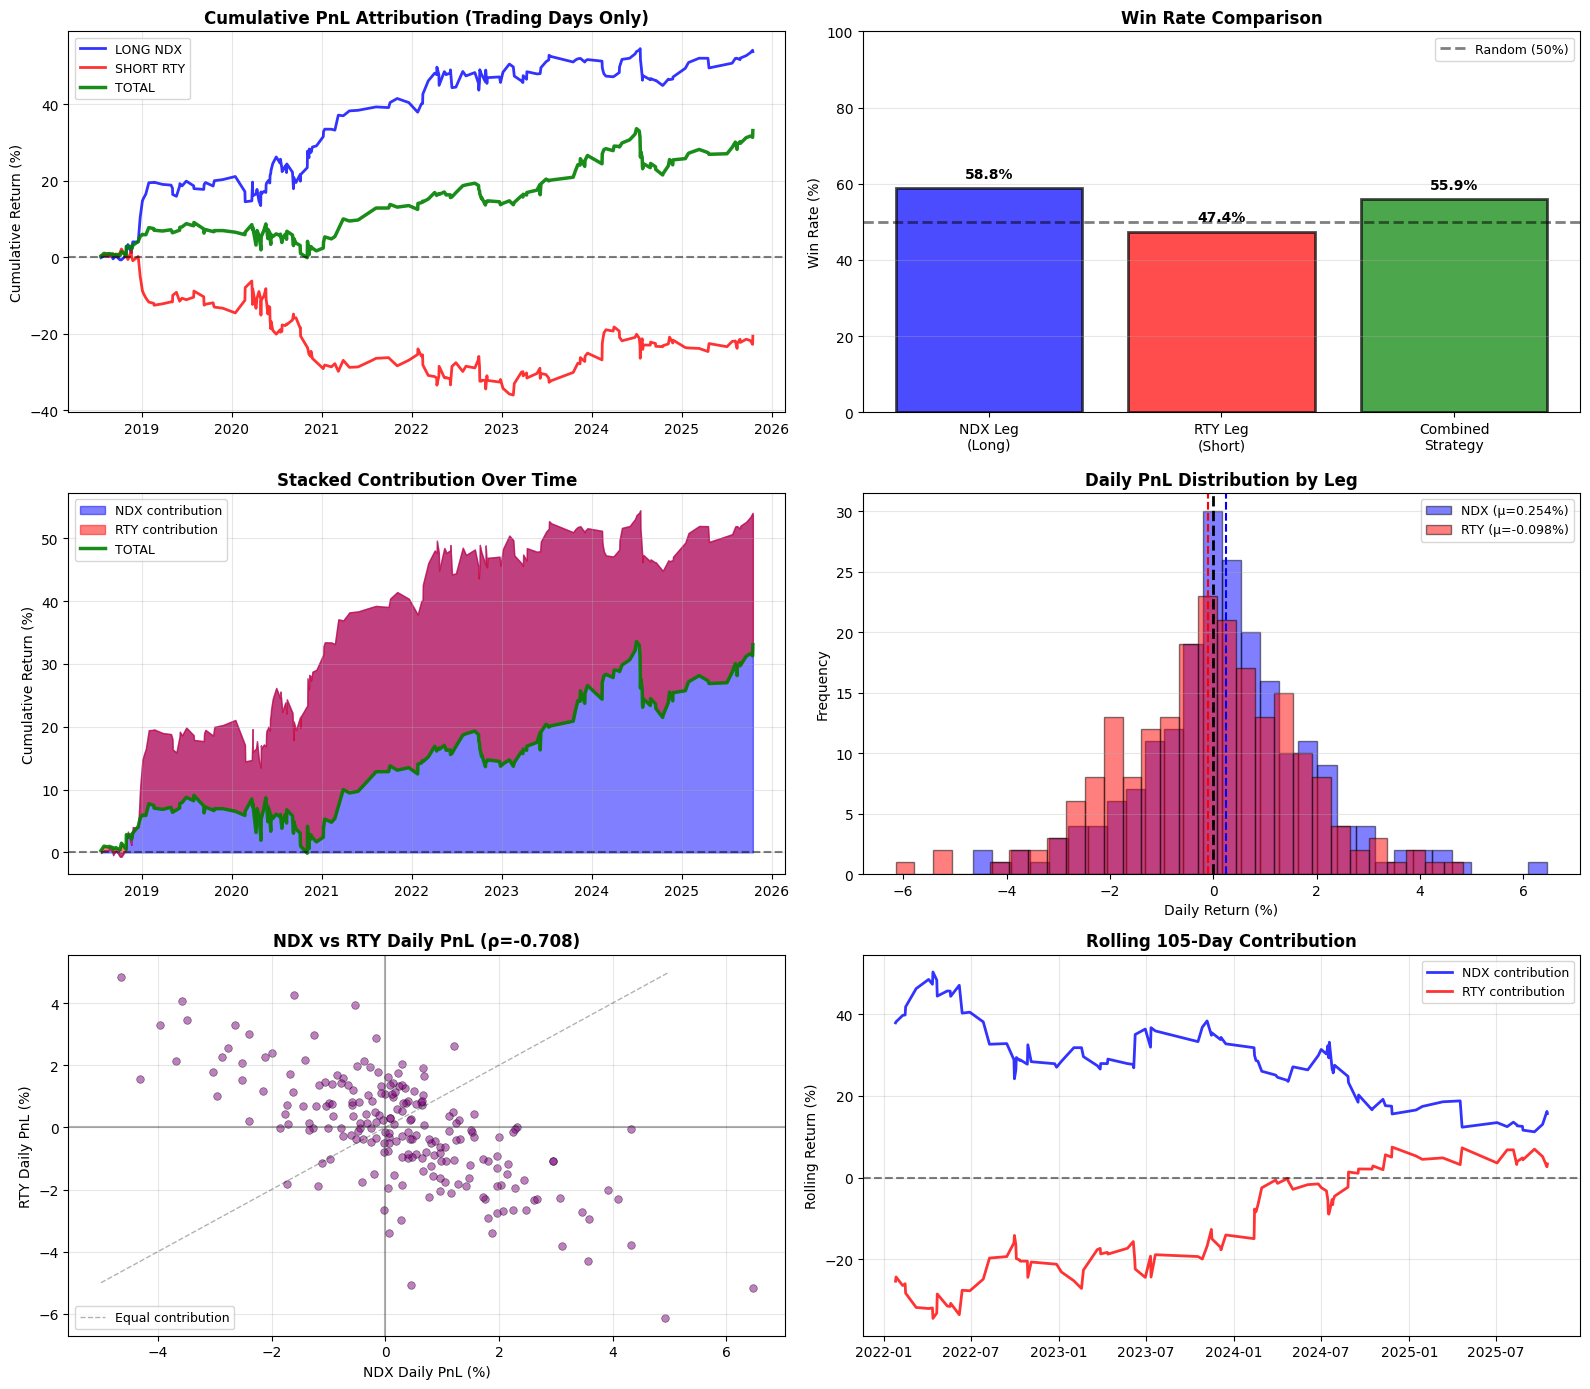

In [11]:
# PNL ATTRIBUTION VISUALIZATION
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# 1. Cumulative PnL by leg
ax1 = axes[0, 0]
ndx_cumul = trading_days["ndx_pnl"].cumsum()
rty_cumul = trading_days["rty_pnl"].cumsum()
total_cumul = ndx_cumul + rty_cumul

ax1.plot(
    ndx_cumul.index,
    ndx_cumul * 100,
    color="blue",
    linewidth=2,
    label="LONG NDX",
    alpha=0.8,
)
ax1.plot(
    rty_cumul.index,
    rty_cumul * 100,
    color="red",
    linewidth=2,
    label="SHORT RTY",
    alpha=0.8,
)
ax1.plot(
    total_cumul.index,
    total_cumul * 100,
    color="green",
    linewidth=2.5,
    label="TOTAL",
    alpha=0.9,
)
ax1.axhline(y=0, color="black", linestyle="--", alpha=0.5)
ax1.set_title(
    "Cumulative PnL Attribution (Trading Days Only)", fontsize=12, fontweight="bold"
)
ax1.set_ylabel("Cumulative Return (%)")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Win Rate Comparison
ax2 = axes[0, 1]
categories = ["NDX Leg\n(Long)", "RTY Leg\n(Short)", "Combined\nStrategy"]
win_rates_vals = [ndx_win_rate, rty_win_rate, win_rate]
colors_wr = ["blue", "red", "green"]

bars = ax2.bar(
    categories,
    win_rates_vals,
    color=colors_wr,
    alpha=0.7,
    edgecolor="black",
    linewidth=2,
)
ax2.axhline(
    y=50, color="black", linestyle="--", linewidth=2, alpha=0.5, label="Random (50%)"
)
ax2.set_ylim(0, 100)
ax2.set_ylabel("Win Rate (%)", fontsize=10)
ax2.set_title("Win Rate Comparison", fontsize=12, fontweight="bold")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis="y")

# Add percentage labels on bars
for i, (bar, val) in enumerate(zip(bars, win_rates_vals)):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 2,
        f"{val:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=10,
    )

# 3. Cumulative Contribution Breakdown (Stacked Area)
ax3 = axes[1, 0]
ax3.fill_between(
    ndx_cumul.index,
    0,
    ndx_cumul * 100,
    color="blue",
    alpha=0.5,
    label="NDX contribution",
)
ax3.fill_between(
    rty_cumul.index,
    ndx_cumul * 100,
    total_cumul * 100,
    color="red",
    alpha=0.5,
    label="RTY contribution",
)
ax3.plot(
    total_cumul.index,
    total_cumul * 100,
    color="green",
    linewidth=2.5,
    label="TOTAL",
    alpha=0.9,
)
ax3.axhline(y=0, color="black", linestyle="--", alpha=0.5)
ax3.set_title("Stacked Contribution Over Time", fontsize=12, fontweight="bold")
ax3.set_ylabel("Cumulative Return (%)")
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Daily PnL distribution by leg
ax4 = axes[1, 1]
ax4.hist(
    trading_days["ndx_pnl"] * 100,
    bins=30,
    alpha=0.5,
    color="blue",
    label=f"NDX (μ={ndx_avg_daily:.3%})",
    edgecolor="black",
)
ax4.hist(
    trading_days["rty_pnl"] * 100,
    bins=30,
    alpha=0.5,
    color="red",
    label=f"RTY (μ={rty_avg_daily:.3%})",
    edgecolor="black",
)
ax4.axvline(x=0, color="black", linestyle="--", linewidth=2)
ax4.axvline(x=ndx_avg_daily * 100, color="blue", linestyle="--", linewidth=1.5)
ax4.axvline(x=rty_avg_daily * 100, color="red", linestyle="--", linewidth=1.5)
ax4.set_title("Daily PnL Distribution by Leg", fontsize=12, fontweight="bold")
ax4.set_xlabel("Daily Return (%)")
ax4.set_ylabel("Frequency")
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis="y")

# 5. Scatter: NDX vs RTY daily PnL
ax5 = axes[2, 0]
ax5.scatter(
    trading_days["ndx_pnl"] * 100,
    trading_days["rty_pnl"] * 100,
    alpha=0.5,
    s=30,
    color="purple",
    edgecolor="black",
    linewidth=0.5,
)
ax5.axhline(y=0, color="black", linestyle="-", alpha=0.3)
ax5.axvline(x=0, color="black", linestyle="-", alpha=0.3)
ax5.plot([-5, 5], [-5, 5], "k--", alpha=0.3, linewidth=1, label="Equal contribution")

# Correlation
corr_legs = trading_days["ndx_pnl"].corr(trading_days["rty_pnl"])
ax5.set_title(
    f"NDX vs RTY Daily PnL (ρ={corr_legs:.3f})", fontsize=12, fontweight="bold"
)
ax5.set_xlabel("NDX Daily PnL (%)")
ax5.set_ylabel("RTY Daily PnL (%)")
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# 6. Rolling contribution (252-day)
ax6 = axes[2, 1]
window = min(252, len(trading_days) // 2)
if len(trading_days) >= window:
    ndx_rolling = trading_days["ndx_pnl"].rolling(window).sum() * 100
    rty_rolling = trading_days["rty_pnl"].rolling(window).sum() * 100

    ax6.plot(
        ndx_rolling.index,
        ndx_rolling,
        color="blue",
        linewidth=2,
        label="NDX contribution",
        alpha=0.8,
    )
    ax6.plot(
        rty_rolling.index,
        rty_rolling,
        color="red",
        linewidth=2,
        label="RTY contribution",
        alpha=0.8,
    )
    ax6.axhline(y=0, color="black", linestyle="--", alpha=0.5)
    ax6.set_title(f"Rolling {window}-Day Contribution", fontsize=12, fontweight="bold")
    ax6.set_ylabel("Rolling Return (%)")
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)
else:
    ax6.text(
        0.5,
        0.5,
        "Insufficient data for rolling analysis",
        ha="center",
        va="center",
        transform=ax6.transAxes,
    )
    ax6.set_title(f"Rolling {window}-Day Contribution", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

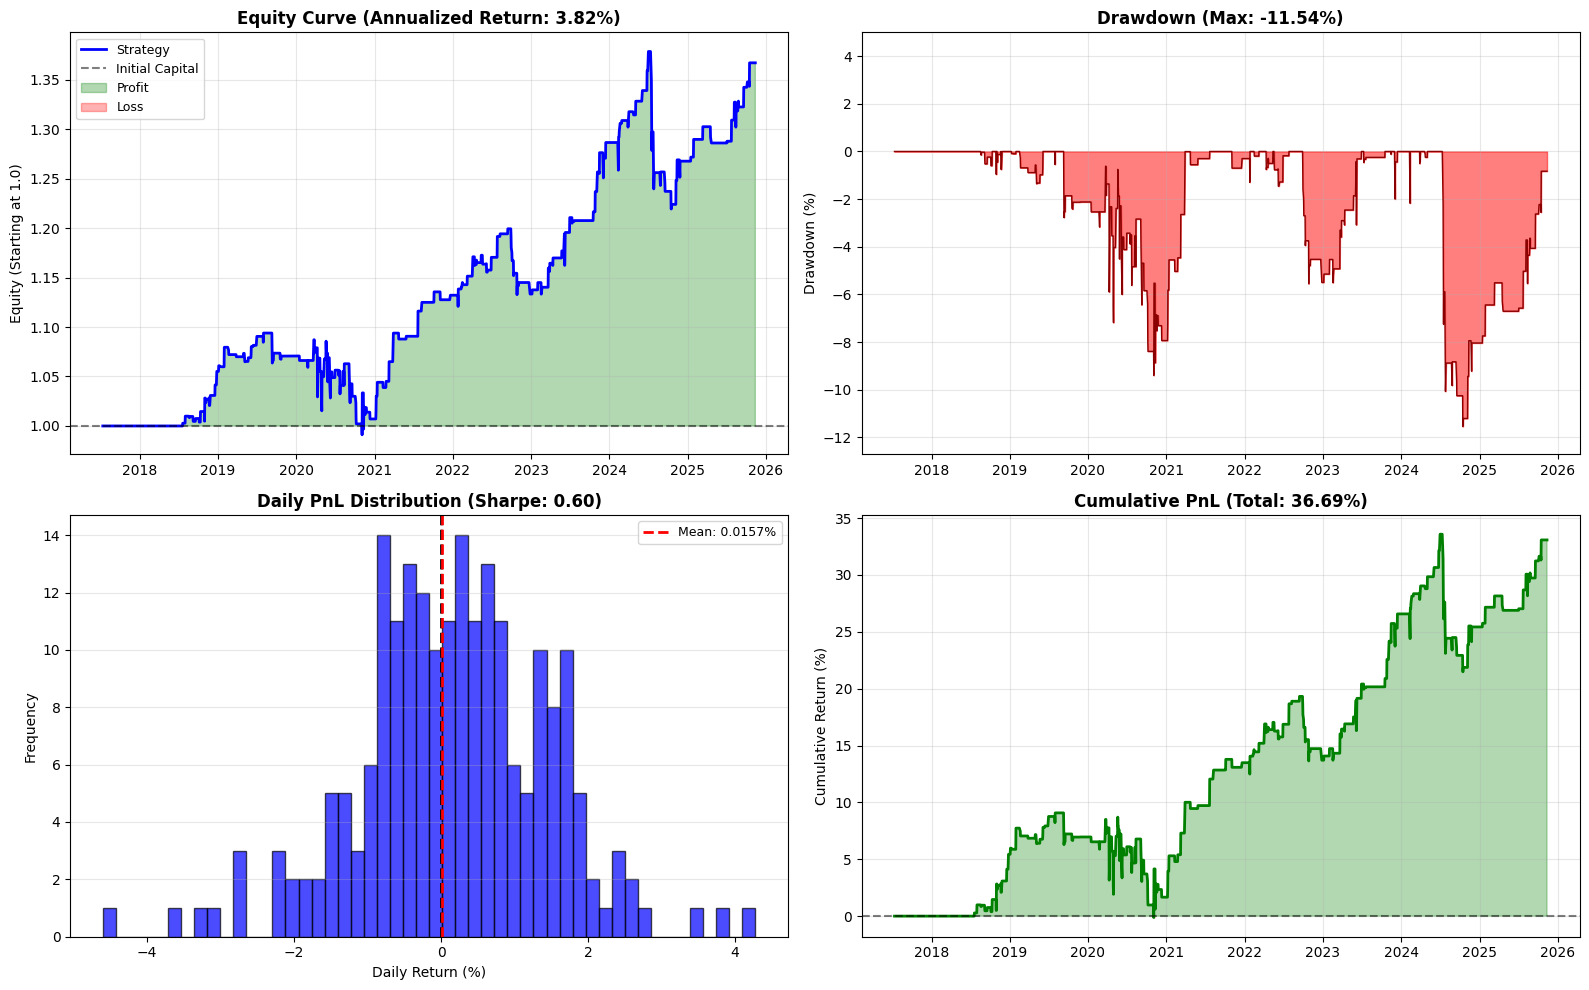

In [12]:
# PNL VISUALIZATIONS
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Equity Curve
ax1 = axes[0, 0]
ax1.plot(
    valid_pnl.index,
    valid_pnl["equity_curve"],
    color="blue",
    linewidth=2,
    label="Strategy",
)
ax1.axhline(y=1, color="black", linestyle="--", alpha=0.5, label="Initial Capital")
ax1.fill_between(
    valid_pnl.index,
    1,
    valid_pnl["equity_curve"],
    where=(valid_pnl["equity_curve"] >= 1),
    alpha=0.3,
    color="green",
    label="Profit",
)
ax1.fill_between(
    valid_pnl.index,
    1,
    valid_pnl["equity_curve"],
    where=(valid_pnl["equity_curve"] < 1),
    alpha=0.3,
    color="red",
    label="Loss",
)
ax1.set_title(
    f"Equity Curve (Annualized Return: {annualized_return:.2%})",
    fontsize=12,
    fontweight="bold",
)
ax1.set_ylabel("Equity (Starting at 1.0)")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Drawdown Chart
ax2 = axes[0, 1]
ax2.fill_between(valid_pnl.index, 0, drawdown * 100, color="red", alpha=0.5)
ax2.plot(valid_pnl.index, drawdown * 100, color="darkred", linewidth=1)
ax2.set_title(f"Drawdown (Max: {max_drawdown:.2%})", fontsize=12, fontweight="bold")
ax2.set_ylabel("Drawdown (%)")
ax2.set_ylim([max_drawdown * 100 * 1.1, 5])
ax2.grid(True, alpha=0.3)

# 3. Daily PnL Distribution
ax3 = axes[1, 0]
trading_pnl = valid_pnl[valid_pnl["position"] != 0]["strategy_pnl"]
ax3.hist(trading_pnl * 100, bins=50, color="blue", alpha=0.7, edgecolor="black")
ax3.axvline(x=0, color="black", linestyle="--", linewidth=2)
ax3.axvline(
    x=mean_daily_return * 100,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {mean_daily_return:.4%}",
)
ax3.set_title(
    f"Daily PnL Distribution (Sharpe: {sharpe_ratio:.2f})",
    fontsize=12,
    fontweight="bold",
)
ax3.set_xlabel("Daily Return (%)")
ax3.set_ylabel("Frequency")
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis="y")

# 4. Cumulative PnL
ax4 = axes[1, 1]
ax4.plot(valid_pnl.index, valid_pnl["cumulative_pnl"] * 100, color="green", linewidth=2)
ax4.axhline(y=0, color="black", linestyle="--", alpha=0.5)
ax4.fill_between(
    valid_pnl.index,
    0,
    valid_pnl["cumulative_pnl"] * 100,
    where=(valid_pnl["cumulative_pnl"] >= 0),
    alpha=0.3,
    color="green",
)
ax4.fill_between(
    valid_pnl.index,
    0,
    valid_pnl["cumulative_pnl"] * 100,
    where=(valid_pnl["cumulative_pnl"] < 0),
    alpha=0.3,
    color="red",
)
ax4.set_title(
    f"Cumulative PnL (Total: {total_return:.2%})", fontsize=12, fontweight="bold"
)
ax4.set_ylabel("Cumulative Return (%)")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)

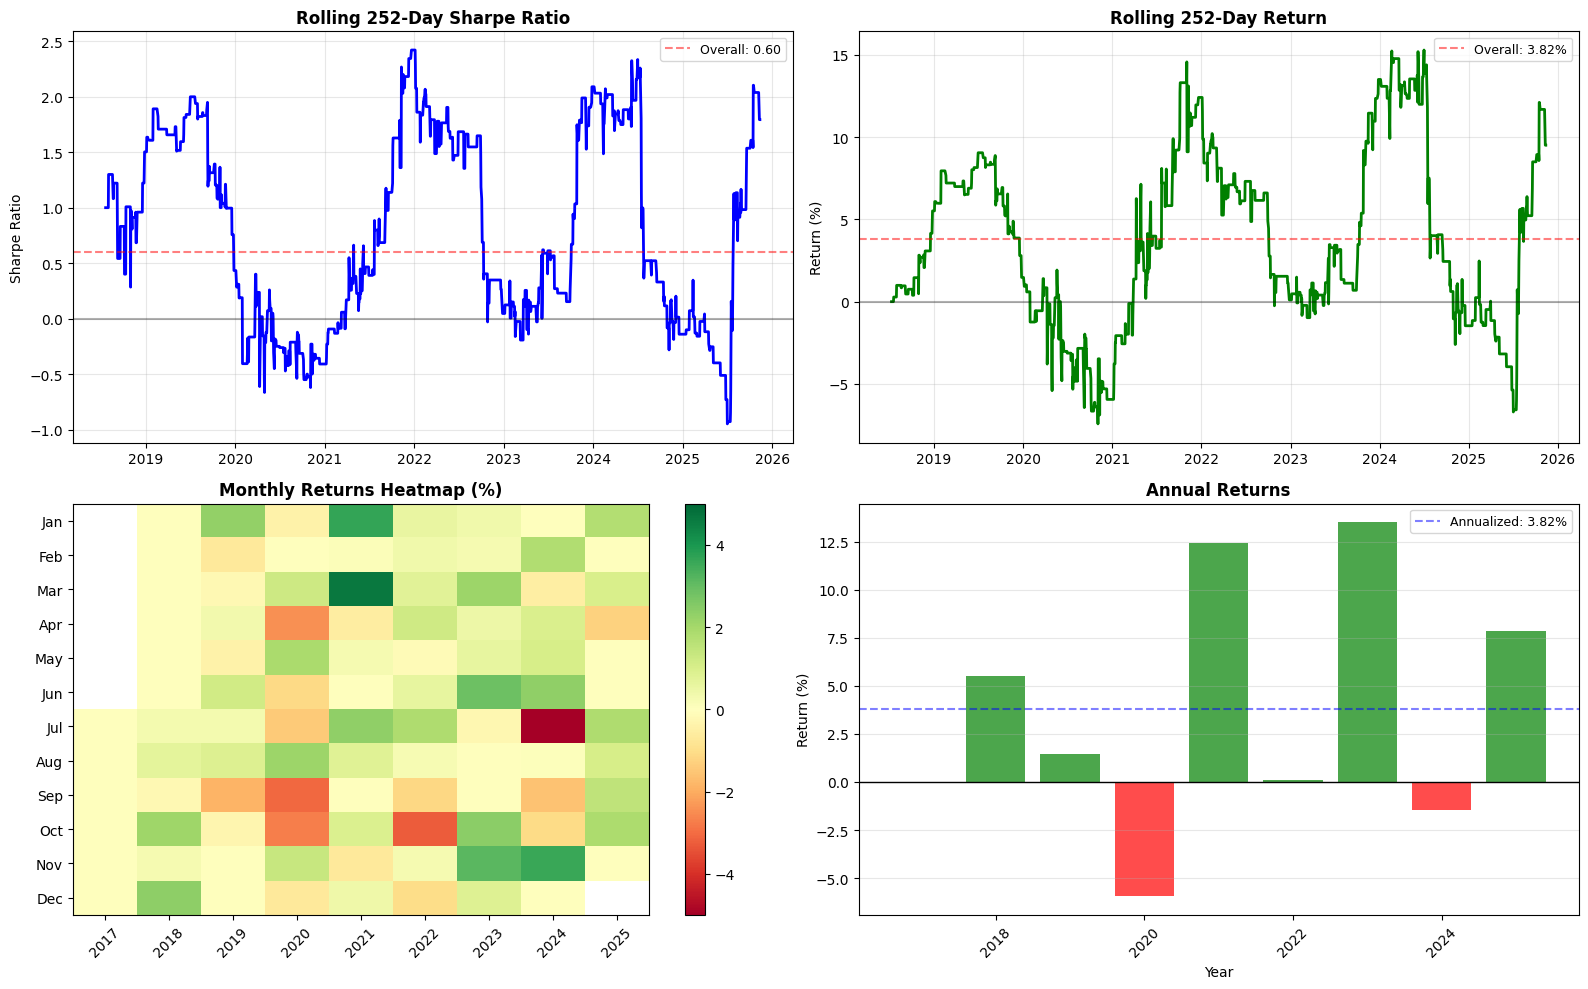

In [13]:
# ROLLING PERFORMANCE METRICS
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Rolling Sharpe Ratio (252-day)
ax1 = axes[0, 0]
rolling_sharpe = (
    valid_pnl["strategy_pnl"].rolling(252).mean()
    / valid_pnl["strategy_pnl"].rolling(252).std()
) * np.sqrt(252)
ax1.plot(rolling_sharpe.index, rolling_sharpe, color="blue", linewidth=2)
ax1.axhline(y=0, color="black", linestyle="-", alpha=0.3)
ax1.axhline(
    y=sharpe_ratio,
    color="red",
    linestyle="--",
    alpha=0.5,
    label=f"Overall: {sharpe_ratio:.2f}",
)
ax1.set_title("Rolling 252-Day Sharpe Ratio", fontsize=12, fontweight="bold")
ax1.set_ylabel("Sharpe Ratio")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Rolling Annualized Return (252-day)
ax2 = axes[0, 1]
rolling_returns = (1 + valid_pnl["strategy_pnl"]).rolling(252).apply(
    lambda x: x.prod(), raw=True
) - 1
ax2.plot(rolling_returns.index, rolling_returns * 100, color="green", linewidth=2)
ax2.axhline(y=0, color="black", linestyle="-", alpha=0.3)
ax2.axhline(
    y=annualized_return * 100,
    color="red",
    linestyle="--",
    alpha=0.5,
    label=f"Overall: {annualized_return:.2%}",
)
ax2.set_title("Rolling 252-Day Return", fontsize=12, fontweight="bold")
ax2.set_ylabel("Return (%)")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Monthly Returns Heatmap
ax3 = axes[1, 0]
monthly_returns = valid_pnl["strategy_pnl"].resample("ME").sum()
monthly_returns_pct = monthly_returns * 100

# Create pivot table for heatmap
monthly_pivot = pd.DataFrame(
    {
        "Year": monthly_returns_pct.index.year,
        "Month": monthly_returns_pct.index.month,
        "Return": monthly_returns_pct.values,
    }
).pivot(index="Month", columns="Year", values="Return")

# Plot heatmap
im = ax3.imshow(monthly_pivot.values, cmap="RdYlGn", aspect="auto", vmin=-5, vmax=5)
ax3.set_yticks(range(12))
ax3.set_yticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
ax3.set_xticks(range(len(monthly_pivot.columns)))
ax3.set_xticklabels(monthly_pivot.columns, rotation=45)
ax3.set_title("Monthly Returns Heatmap (%)", fontsize=12, fontweight="bold")
plt.colorbar(im, ax=ax3)

# 4. Annual Returns Bar Chart
ax4 = axes[1, 1]
annual_returns = (
    valid_pnl["strategy_pnl"].resample("YE").apply(lambda x: (1 + x).prod() - 1)
)
annual_returns_pct = annual_returns * 100
colors = ["green" if x > 0 else "red" for x in annual_returns_pct]
ax4.bar(
    annual_returns_pct.index.year, annual_returns_pct.values, color=colors, alpha=0.7
)
ax4.axhline(y=0, color="black", linestyle="-", linewidth=1)
ax4.axhline(
    y=annualized_return * 100,
    color="blue",
    linestyle="--",
    alpha=0.5,
    label=f"Annualized: {annualized_return:.2%}",
)
ax4.set_title("Annual Returns", fontsize=12, fontweight="bold")
ax4.set_xlabel("Year")
ax4.set_ylabel("Return (%)")
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis="y")
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()